# Exploring River, WWTP, and oceanic nutrient sourcing by Optimization report regions
The goal of this notebook is to explore the sources of total, annual nutrient loading in each region. 
Some assumptions:
- Reference case represents pre-anthropogenic loading and can estimate the net ocean loading in each region
- 2014 case represents the net total of both ocean loading and anthropogenic loading in each region
- An estimate of the amount of advected nutrients from non-local sourcing can be achieved by removing the reference loading (ocean), local WWTP loadings, and local river loadings and scaling the result by "regional residence time / mean residence time across regions", see note below.
- Once an estimate of advected nutrients is calculated then we can compare local sourcing to advected sourcing, by region.  We can also look at things like the change in local sourcing (from reference) vs. advected sourcing.

Note: Adding NO3 in existing and reference cases isn't a true reflection of nutrient loading because nutrient sources will stay in a region for a given residence time, which is likely different between regions.  Summing the loading over time will "double count" inputs.  Inputs will also be repeat counted due to advection and summing over space.  What does this mean?  Comparing values between regions will be biased by residence times.  A shorter residence time will mean less repeat counts of nutrient loading; a longer residence time will mean more repeat counts of nutrient loading.  The physical system remains the same between  the reference and existing cases, meaning that the residence time in each basin ought to be the same between these two cases.  Subtracting the total loadings from the reference case from the total loadings from the 2014 case ought to remove the ocean portion.  This residual value then reflects local AND non-local (advected) anthropogenic sources...but it will still repeat count these values based on how long this loading stays in the region. The ration of this residual value to the WWTP and River inputs will be a metric of (a) residence time, (b) non-local sourcing.  We now have an esimate of residence times for each region from Khangaonkar et al. (2022).  If we scale this residual by the estimated residence time (regional residence time / mean residence time across regions) then the result will show the relative importance of non-local, anthropogenic loading to each region.    

Alternatively, use monthly maximum NO3 from model results? 

In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MaxNLocator
import pandas as pd
import numpy as np
import yaml
import xarray as xr
import pathlib
import geopandas as gpd

In [2]:
case = 'whidbey'

### Load shapefile to get nodes for identifying regions

In [3]:
# Get totals by region
with open(f'../etc/SSM_config_{case}.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
# get shapefile path    
shp = ssm['paths']['shapefile']
# load shapefile into geopandas dataframe
gdf = gpd.read_file(shp)
gdf=gdf.rename(columns={'region_inf':'Regions'})
regions = gdf[['node_id','Regions']].groupby(
        'Regions').count().index.to_list()
regions.remove('Other')
regions

['Hood', 'Main', 'SJF_Admiralty', 'SOG_Bellingham', 'South_Sound', 'Whidbey']

# Calculate river and WWTP loading

In [4]:
# The following WWTP names are from the "Table NLoading1" tab of 
# https://uwnetid.sharepoint.com/:x:/r/sites/og_uwt_psi/_layouts/15/Doc.aspx?sourcedoc=%7B3788B09C-126F-40BF-86AF-22DEC185E831%7D&file=SOG_NB_Figures%26Tables.xlsx&action=default&mobileredirect=true

# The two spaces in front of names reflects formatting of column names in 
# excel spreadsheet
WWTP_names = [
  "  Coupeville",
  "  Everett Snohomish",
  "  La Conner",
  "  Lake Stevens 002",
  "  Langley",
  "  Marysville",
  "  Mt Vernon",
  "  Mukilteo",
  "  Oak Harbor Lagoon",
  "  OF100",
  "  Penn Cove",
  "  Skagit County 2 Big Lake",
  "  Snohomish",
  "  Stanwood",
  "  Swinomish",
  "  Tulalip",
  "  Warm Beach Campground"
]

# Some rivers discharge into more than one node and have nutrient
# loading in two columns (namely: Nooksack and Samish Bell).
# Nutrient loading for these rivers is the sum of the columns
river_names = [
  "  Skagit R_1",
  "  Skagit R_2",
  "  Snohomish R_1",
  "  Snohomish R_2",
  "  Stillaguamish R_1",
  "  Stillaguamish R_2",
  "  Whidbey east"
]
# load setup information
with open(f'../etc/SSM_config_{case}.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
# rename existing and reference tags to match Su Kyong's labels
ssm['run_information']['run_tag']['whidbey']['wqm_baseline'] = "exist"
ssm['run_information']['run_tag']['whidbey']['wqm_reference'] = "ref"

In [5]:
NO3NO2_xlxs='/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-spreadsheets/NO3NO2_load_timeseries.xlsx'
NH4_xlxs='/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-spreadsheets/NH4_load_timeseries.xlsx'
out_dir = "/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/whidbey/nutrient_loading"

# Initialize dataframes

In [6]:
# rivers
river_df={}
riverNO3NO2_df={}

# wwtps
wwtp_df={}
wwtpNO3NO2_df={}

# results
# dataframe to create pie chart showing proportional loading
pie_NO3_df = {}
pie_NO3_df['wwtp'] = {}
pie_NO3_df['rivers'] = {}

# Calculate total, annual WWTP loading for reference and existing cases

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


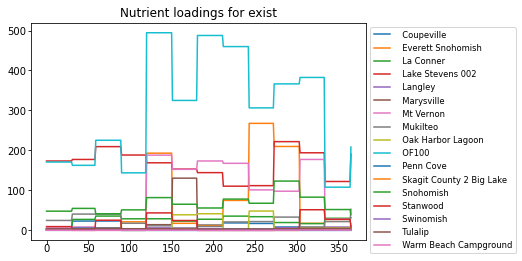

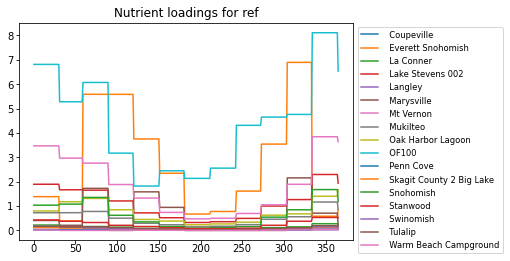

In [7]:
for idx,run_tag in enumerate(['exist','ref']):
    # read in data
    # spreadsheets in workbook organized by names in format of, e.g., "ssm_pnt_wq_exist"
    # I use the run tags to select the desired spreadsheet
    wwtpNO3NO2_df[run_tag] = pd.read_excel(
        NO3NO2_xlxs,
        sheet_name=f'ssm_pnt_wq_{run_tag}',
        usecols=WWTP_names
    )  
    wwtp_df[run_tag]=wwtpNO3NO2_df[run_tag]
    
    # Sum over time to get total, annual loading
    pie_NO3_df['wwtp'][run_tag]=wwtpNO3NO2_df[run_tag].sum(axis=0)

    # The column names have spaces in front of the names.  
    wwtp_df[run_tag].plot()
    plt.legend(loc=2,bbox_to_anchor=(1.0, 1.0))
    plt.title(f"Nutrient loadings for {run_tag}")
    plt.savefig(
        f'{out_dir}/ssm_pnt_wq_{run_tag}.png', 
        dpi=300,
        bbox_inches='tight'
    )

# Calculate total, annual river loading for reference and existing cases

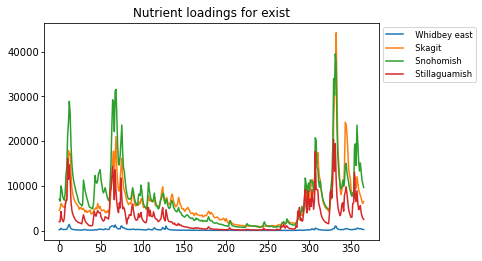

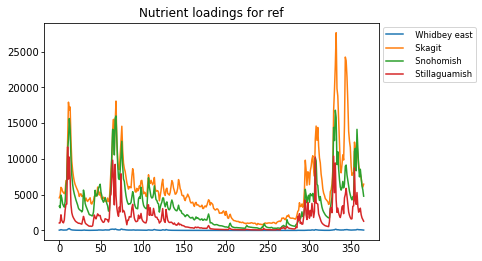

In [8]:
for idx,run_tag in enumerate(['exist','ref']):
    # read in data
    # spreadsheets in workbook organized by names in format of, e.g., "ssm_pnt_wq_exist"
    # I use the run tags to select the desired spreadsheet
    riverNO3NO2_df[run_tag] = pd.read_excel(
        NO3NO2_xlxs,
        sheet_name=f'ssm_pnt_wq_{run_tag}',
        usecols=river_names
    )
    # combine all nitrogen loading
    river_df[run_tag]=riverNO3NO2_df[run_tag]
    # combine Skagit, Snohomish, and Stillaguamish
    river_df[run_tag]["  Skagit"]=river_df[run_tag]["  Skagit R_1"] + river_df[run_tag]["  Skagit R_2"]
    river_df[run_tag]["  Snohomish"]=river_df[run_tag]["  Snohomish R_1"] + river_df[run_tag]["  Snohomish R_2"]
    river_df[run_tag]["  Stillaguamish"]=river_df[run_tag]["  Stillaguamish R_1"] + river_df[run_tag]["  Stillaguamish R_2"]
    river_df[run_tag] = river_df[run_tag].drop("  Skagit R_1", axis=1)
    river_df[run_tag] = river_df[run_tag].drop("  Skagit R_2", axis=1)
    river_df[run_tag] = river_df[run_tag].drop("  Snohomish R_1", axis=1)
    river_df[run_tag] = river_df[run_tag].drop("  Snohomish R_2", axis=1)
    river_df[run_tag] = river_df[run_tag].drop("  Stillaguamish R_1", axis=1)
    river_df[run_tag] = river_df[run_tag].drop("  Stillaguamish R_2", axis=1)
    
    # Sum over time to get total, annual loading
    pie_NO3_df['rivers'][run_tag]=riverNO3NO2_df[run_tag].sum(axis=0)
    
    # The column names have spaces in front of the names.  
    river_df[run_tag].plot()
    plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0))
    plt.title(f"Nutrient loadings for {run_tag}")
    plt.savefig(
        f'{out_dir}/ssm_pnt_wq_{run_tag}_rivers.png', 
        dpi=300,
        bbox_inches='tight'
    )

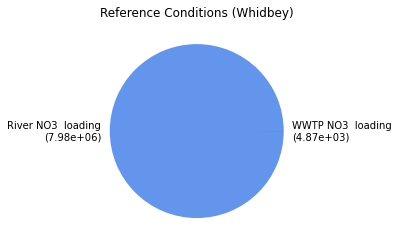

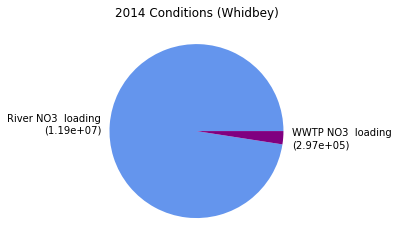

In [62]:
for run in ['ref','exist']:
    plt.figure()
    pie = [pie_NO3_df['rivers'][run].sum(),pie_NO3_df['wwtp'][run].sum()]
    plt.pie(pie, 
            colors=['cornflowerblue','purple'],
           labels=[f"River NO3  loading\n({pie_NO3_df['rivers'][run].sum():.2e})", f"WWTP NO3  loading\n({pie_NO3_df['wwtp'][run].sum():.2e})"],
           )
    if run == 'exist':
        plt.title("2014 Conditions (Whidbey)",fontsize=12)
    if run == 'ref':
        plt.title("Reference Conditions (Whidbey)",fontsize=12)       

# Residence time
Based on [Premathilake and Khangaonkar (2022)](https://reader.elsevier.com/reader/sd/pii/S0272771422002803?token=E492D58702442B57079EA448420E37A5963419AD5F81C4473ECD197487F84E19744F57F8E84CEA844E5C6C8859741975&originRegion=us-east-1&originCreation=20221117182050), Table 8. 

In [9]:
avg_residence_time = (48+28+28+20)/4
residence_time={
    'SOG':48,
    'Puget':np.NaN,
    'Hood':28,
    'Whidbey':28,
    'South Sound':20,
}
# divide by scaling to normalize results
residence_time_scaling = {
    'SOG':48/avg_residence_time,
    'Puget':np.NaN,
    'Hood':28/avg_residence_time,
    'Whidbey':28/avg_residence_time,
    'South Sound':20/avg_residence_time,
}

# Ocean loading
- Calculate NO3 monthly total as sum in depth and time by region
- Calculate NO3 monthly total as sum over depth and region of monthly-averaged values 

In [10]:
daily_mean_nc={}
daily_sum_nc={}
# baseline files
base_netcdf_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/whidbey/NO3/wqm_baseline/wc')
daily_mean_nc['base'] = base_netcdf_dir/'daily_mean_NO3_wc.nc'
daily_sum_nc['base'] = base_netcdf_dir/'daily_sum_NO3_wc.nc'
# reference files
ref_netcdf_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/whidbey/NO3/wqm_reference/wc')
daily_mean_nc['ref'] = ref_netcdf_dir/'daily_mean_NO3_wc.nc'
daily_sum_nc['ref'] = ref_netcdf_dir/'daily_sum_NO3_wc.nc'

In [11]:
# dataframe for netcdf information
xr_mean={}
xr_sum={}
# dataframe for regional sums
total_mean={}
total_sum={}

# load netcdf and calculate regional sums
for run in ['ref','base']:
    xr_3D_mean = xr.open_dataset(daily_mean_nc[run], engine='netcdf4')
    xr_3D_sum = xr.open_dataset(daily_sum_nc[run], engine='netcdf4')
    
    # average NO3 across depth and time for 2014, by node
    xr_mean[run] = xr_3D_mean.mean(dim='dim_0').mean(dim='dim_1')
    # total nutrients over depth and time in 2014, by node
    xr_sum[run] = xr_3D_sum.sum(dim='dim_0').sum(dim='dim_1')
    
    # initialize dataframes
    total_mean[run]={}
    total_sum[run]={}
    for region in regions: 
        # create boolean of indices where True selects nodes of 
        # specified Region 
        idx = ((gdf['Regions']==region) &
               (gdf['included_i']==1)) 
        # # indexing xarray directly pulled numpy.nd error
        # total_mean[run][region]=xr_mean[run].NO3_daily_mean_wc[idx].sum().item()
        # total_sum[run][region]=xr_sum[run].NO3_daily_sum_wc[idx].sum().item()
        # here is a work-around solution
        gdf['NO3_mean']=xr_mean[run].NO3_daily_mean_wc
        gdf['NO3_sum']=xr_sum[run].NO3_daily_sum_wc
        total_mean[run][region]=gdf['NO3_mean'][idx].sum().item()
        total_sum[run][region]=gdf['NO3_sum'][idx].sum().item()
        

In [12]:
mean_df = pd.DataFrame(total_mean)
sum_df = pd.DataFrame(total_sum)

Text(0, 0.5, 'Sum across regions of mean NO3 values')

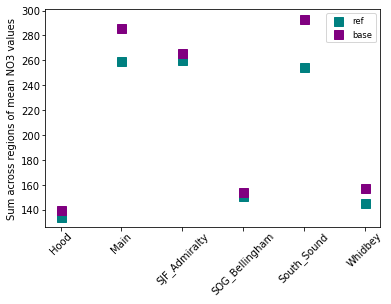

In [58]:
ax=mean_df.plot(
    marker='s',
    markersize=9,
    lw=0,
    color=[ssm['line']['color']['wqm_reference'],ssm['line']['color']['wqm_baseline']]
)
plt.xticks(rotation = 45)
plt.ylabel('Sum across regions of mean NO3 values')

In [24]:
sum_df=sum_df.reindex(['base','ref'], axis=1)
sum_df=sum_df.rename(columns={'ref':'Model Sum (Reference)','base':'Model Sum (2014)'})

Text(0, 0.5, 'Sum across regions of total NO3')

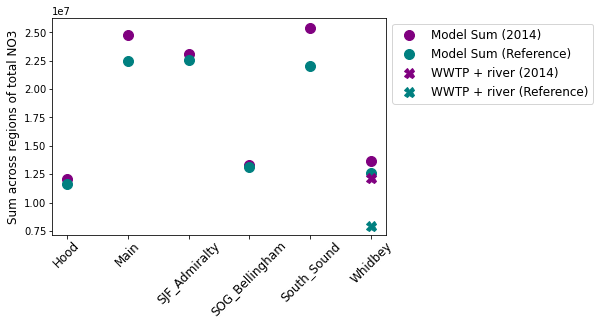

In [32]:
ax=sum_df.plot(
    marker='o',
    markersize=10,
    lw=0,
    color=[ssm['line']['color']['wqm_baseline'],ssm['line']['color']['wqm_reference']]
)
plt.plot(5,pie_NO3_df['wwtp']['exist'].sum()+pie_NO3_df['rivers']['exist'].sum(),
         'X',
         markersize=10,
         color=ssm['line']['color']['wqm_baseline'],
        label='WWTP + river (2014)')
plt.plot(5,pie_NO3_df['wwtp']['ref'].sum()+pie_NO3_df['rivers']['ref'].sum(),
         'X',
         markersize=10,
         color=ssm['line']['color']['wqm_reference'],
        label='WWTP + river (Reference)')
plt.legend(loc=2,bbox_to_anchor=(1, 1), fontsize=12)
plt.xticks(rotation = 45, fontsize=12)
plt.ylabel('Sum across regions of total NO3', fontsize=12)

<AxesSubplot:>

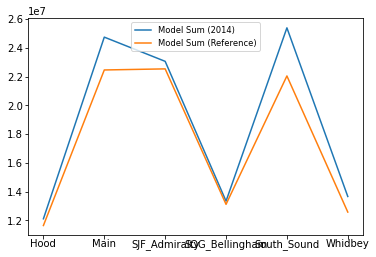

In [33]:
sum_df.plot()